# Batch UCB


In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

**Update 13/Nov/2020** Generate recommendation for round 2 (with partial replicates for round 0 and 1)

In [2]:
Path = '../../data/Results_Microplate_partialTrue_normTrue_roundRep_formatSeq_logTrue.csv'

known_df = pd.read_csv(Path)
known_df.head()

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,...,Round,Unnamed: 16,Rep7,Rep8,Rep9,RBS6,index,Pred Mean,Pred Std,Pred UCB
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,2.433056,2.502155,2.315237,3.012905,2.917124,2.275329,2.575968,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
1,1,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.556251,1.654243,1.762146,1.790123,2.312790,1.959275,1.839138,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
2,2,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.603551,0.748674,0.921939,0.391285,0.503846,0.711231,0.646754,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
3,3,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.658359,1.874275,1.534988,1.546110,1.747116,1.232548,1.598899,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
4,4,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.545942,2.072095,1.386300,1.949759,1.774833,2.146898,1.812638,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN


In [3]:
# known_df = known_df[known_df['Group'] != 'bps_noncore']
# known_df.reset_index(inplace=True, drop=True)
# known_df['RBS'] = known_df['RBS6']
# known_df

## Conclusion of pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Kernel: codes/kernels_for_GPK.py
    - weighted degree kernel with shift
    - normalisation: centering; unit variance; normalisation over the whole (train + test) kernel
    - l = 6 (maximum substring length)
    - s = 1 (shift)
    - sigma0 = 1 (signal std)
- Regression: codes/regression.py
    - Gaussian Process Regression
    - train on samples (multi-label) from first round result, i.e. train shape:  (1055, 20)
    - predict on all design space (4 * 6) except known sequences, i.e. test shape:  (3961, 20)
    - alpha = 2
- Recommendation: codes/batch_ucb.py
    - batch UCB (GP-BUCB)
    - beta = 2
    - recommendation size = 90

In [4]:
rec_size = 90
l = 6
s = 1
beta = 2
alpha = 2
sigma_0 = 2
kernel_name = 'WD_Kernel_Shift'
embedding = 'label'

## Top n recommendations

return seuqneces with top n ucb score. 

In [5]:
top_n = Top_n_ucb(known_df, kernel_name=kernel_name, l=l, s=s, sigma_0=sigma_0,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta)

In [6]:
top_n_rec_df = top_n.run_experiment()

X train shape:  (1328, 20)
X test shape:  (3873, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg


(array([ 15.,  51., 135., 272., 471., 756., 932., 816., 360.,  65.]),
 array([0.50220102, 0.55697182, 0.61174261, 0.66651341, 0.7212842 ,
        0.776055  , 0.83082579, 0.88559659, 0.94036738, 0.99513818,
        1.04990897]),
 <a list of 10 Patch objects>)

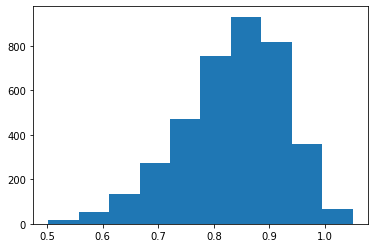

In [7]:
plt.hist(top_n.df_design['pred std'])

(array([ 2.,  0.,  2.,  6., 12., 14., 12., 11., 21., 10.]),
 array([0.72888865, 0.76099068, 0.79309271, 0.82519475, 0.85729678,
        0.88939881, 0.92150084, 0.95360288, 0.98570491, 1.01780694,
        1.04990897]),
 <a list of 10 Patch objects>)

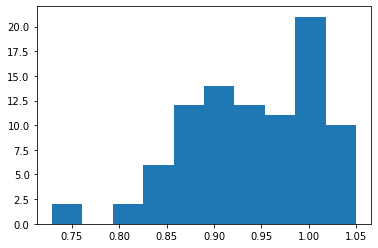

In [8]:
plt.hist(top_n_rec_df['pred std'])

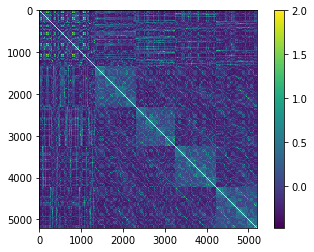

In [9]:
kernel_matrix = top_n.gpr.wd_kernel_instance.kernel_all_normalised
plt.imshow(kernel_matrix)
plt.colorbar()

## GP-BUCB

Desautels et al. 2014 Algorithm 2
http://jmlr.org/papers/volume15/desautels14a/desautels14a.pdf

In [10]:
gpbucb = GP_BUCB(known_df, kernel_name=kernel_name, l=l, s=s,sigma_0=sigma_0,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta)

In [11]:
gpbucb_rec_df = gpbucb.run_experiment()

X train shape:  (1328, 20)
X test shape:  (3873, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (267, 28)
X train shape:  (1329, 20)
X test shape:  (3872, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (268, 28)
X train shape:  (1330, 20)
X test shape:  (3871, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (269, 28)
X train shape:  (1331, 20)
X test shape:  (3870, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (270, 28)
X train shape:  (1332, 20)
X test shape:  (3869, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (271, 28)
X train shape:  (1333, 20)
X test shape:  (3868, 20)
create kernel instance
init kernel
finish creating kernel instance


## Recommendation results

In [12]:
gpbucb_rec_df

,level_0,AVERAGE,Group,Name,PERC,Plate,Pred Mean,Pred Std,Pred UCB,RBS,...,STD,Unnamed: 0,Unnamed: 16,Usable,index,train_test,label,pred mean,pred std,ucb
0,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACAGGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.992886,1.011485,3.015856
1,1363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.070332,0.925203,2.920738
2,1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.224077,0.804958,2.833993
3,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACAGGTTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.897474,0.962386,2.822246
4,1352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCATTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.035825,0.876327,2.788479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACTTGAGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.683590,0.768159,2.219908
86,3014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATAGTGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.843365,0.688149,2.219663
87,1410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGTATTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.711835,0.753031,2.217896
88,2652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACCTTCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.532692,0.842275,2.217242


In [13]:
top_n_rec_df

,level_0,AVERAGE,Group,Name,PERC,Plate,Pred Mean,Pred Std,Pred UCB,RBS,...,STD,Unnamed: 0,Unnamed: 16,Usable,index,train_test,label,pred mean,pred std,ucb
2274,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACAGGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.992886,1.011485,3.015856
1566,1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.224077,0.869313,2.962702
1629,1363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.070332,0.943935,2.958202
2031,1765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGTGGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.914916,1.016561,2.948038
2278,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACAGGTTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.897474,0.992141,2.881756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAATGGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.468362,1.005600,2.479563
2581,2315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACGCGCTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.599207,0.940177,2.479561
1388,1122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGACATTTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.582359,0.947673,2.477705
2378,2112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACATAGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.620968,0.927254,2.475475


In [14]:
top_n_rec_df.index

Int64Index([2274, 1566, 1629, 2031, 2278, 3980, 2336, 2150, 1688, 1400, 2400,
            2886, 3317, 2264, 1570, 3254, 1618, 1633, 2035, 2291, 2870, 2874,
            3984, 2340, 1614,  417, 3258, 1404,  596, 3132, 2384, 2284, 2021,
            2294, 3497, 1635, 2326,  657, 3321, 2864, 2271, 3970, 1390, 2265,
            3244, 2154, 2890, 2293, 3378, 1608, 1563,  967, 1639, 1678, 2258,
            2028, 3549, 1646, 2390, 2048, 2520, 2141, 3307, 2388, 2330, 1462,
            3011, 3073, 4106, 2876, 2827, 1615, 3271, 2280, 2041, 2272, 1620,
            1394,  600, 1617, 3977, 1626, 2909, 2404, 2703, 1090, 2581, 1388,
            2378, 1649],
           dtype='int64')

### Similarity between recommendations

characterized by the same kernel used for prediction.

init kernel
init kernel
init kernel


Text(0.5, 1.0, 'GP_BUCB hist')

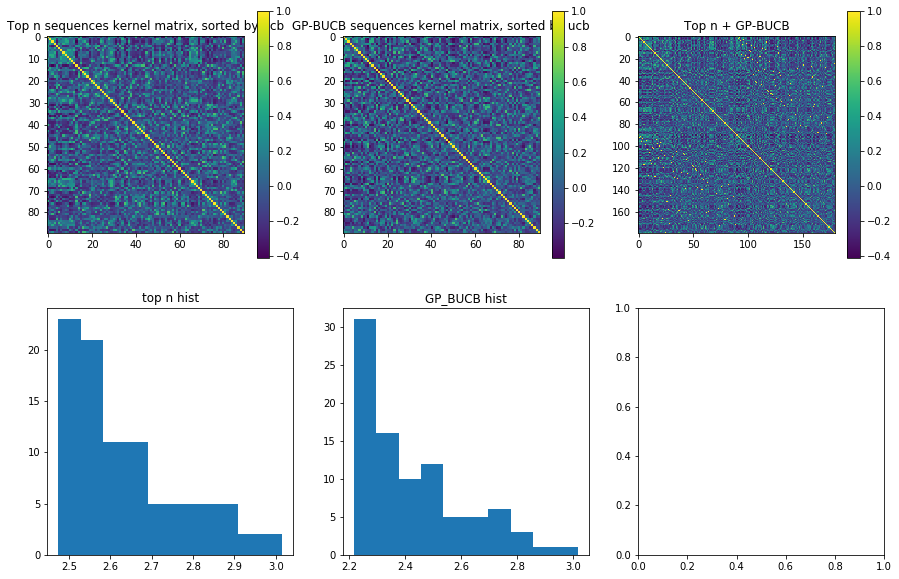

In [15]:
num_rows = 2
num_cols = 3

wd_kernel = WD_Shift_Kernel
fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

wd_kernel.INIT_FLAG = False
im = a[0][0].imshow(wd_kernel(l=6, features = np.asarray(top_n_rec_df['RBS'])).kernel_all_normalised, cmap = 'viridis')
fig.colorbar(im, ax =a[0][0])
a[0][0].set_title('Top n sequences kernel matrix, sorted by ucb')

wd_kernel.INIT_FLAG = False
im = a[0][1].imshow(wd_kernel(l=6, features = np.asarray(gpbucb_rec_df['RBS'])).kernel_all_normalised, cmap = 'viridis')
fig.colorbar(im, ax =a[0][1])
a[0][1].set_title('GP-BUCB sequences kernel matrix, sorted by ucb')

wd_kernel.INIT_FLAG = False
all_features = np.concatenate((np.asarray(top_n_rec_df['RBS']), np.asarray(gpbucb_rec_df['RBS'])), axis = 0)
im = a[0][2].imshow(wd_kernel(l=6, features = all_features).kernel_all_normalised, cmap = 'viridis')
fig.colorbar(im, ax =a[0][2])
a[0][2].set_title('Top n + GP-BUCB')

im = a[1][0].hist(top_n_rec_df['ucb'])
a[1][0].set_title('top n hist')

im = a[1][1].hist(gpbucb_rec_df['ucb'])
a[1][1].set_title('GP_BUCB hist')

# im = a[1][2].hist(gpbucb_rec_df['ucb'])
# a[1][2].set_title('GP_BUCB hist')

In [16]:
common_rec = set(top_n_rec_df['RBS']).intersection(set(gpbucb_rec_df['RBS']))
print('Number of intersection of recommendations: ', len(common_rec))

Number of intersection of recommendations:  66


In [17]:
para_name = '_alpha' + str(alpha) + '_beta' + str(beta)

with pd.ExcelWriter('batch_ucb.xlsx', engine="openpyxl", mode='r') as writer:
    top_n_rec_df.to_excel(writer, sheet_name = 'top_n_core_' + para_name)
    gpbucb_rec_df.to_excel(writer, sheet_name = 'gpbucb_core_' + para_name)